In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import os

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 数据集类
class NPYDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        try:
            self.annotations = pd.read_csv(csv_file, encoding='utf-8')
        except UnicodeDecodeError:
            self.annotations = pd.read_csv(csv_file, encoding='gbk')
        self.root_dir = root_dir
        self.le = LabelEncoder()
        self.annotations['labels'] = self.annotations['labels'].apply(lambda x: x.strip("[]'"))
        self.annotations['labels'] = self.le.fit_transform(self.annotations['labels'])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, str(self.annotations.iloc[index, -1]) + '.npy')
        image = np.load(img_name)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = self.annotations.iloc[index, 2]
        return image, label

# 模型定义
class ResNet2D(nn.Module):
    def __init__(self, num_classes):
        super(ResNet2D, self).__init__()
        # 使用ResNet50作为基础模型
        self.resnet = models.resnet50(pretrained=True)
        # 冻结预训练模型的参数
        for param in self.resnet.parameters():
            param.requires_grad = False

        # 替换全连接层以适应新的分类任务
        num_ftrs = self.resnet.fc.in_features  # 获取全连接层的输入特征数
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)  # 替换全连接层

    def forward(self, x):
        x = self.resnet(x)
        return x

# 之后的优化器、学习率调度器和训练循环可以保持不变

# 训练和评估参数
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据加载
train_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\train.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_gaus_train')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\all_gaus_double_test.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\all_normalized_double_test_images')
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

validation_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\validation.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_gaus_validation')
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

# 模型初始化
num_classes = len(np.unique(train_dataset.annotations['labels']))

# 创建一个权重数组
# 这里假设类别标签已经编码为0, 1
weights = torch.tensor([1.0, 1.0], dtype=torch.float32).to(device)

# 使用加权损失函数
criterion = nn.CrossEntropyLoss(weight=weights)

model = ResNet2D(num_classes=num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)  # 增加权重衰减

# 学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 训练模型的代码...
# 请根据您的具体需求添加训练循环和验证/测试循环

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model_path = r'C:\Users\HP\Desktop\指南者\项目\眼病预测\gaus_D_N classification\trained_model.pth'  # 指定模型保存路径

In [6]:
# 创建与之前相同的模型实例
# 请将num_classes替换为您实际使用的类别数
model = ResNet2D(num_classes=2)

# 加载保存的模型状态字典，确保映射到CPU
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# 如果你要继续在训练模式下使用模型，别忘了调用 model.train()
# 如果是用于评估或预测，调用 model.eval()

<All keys matched successfully>

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # 收集所有预测和标签
        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

    # 计算准确率
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')
    
    # 计算精确率、召回率和F1分数
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

Accuracy of the model on the test images: 97.99 %
Precision: 0.9800
Recall: 0.9799
F1 Score: 0.9799


In [8]:
from sklearn.metrics import roc_auc_score
# 计算AUC分数
auc_score = roc_auc_score(all_labels, all_preds)

print(f'AUC Score: {auc_score:.4f}')

AUC Score: 0.9800


In [9]:
# 打印所有预测结果
print('All Predictions:', all_preds)

All Predictions: [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]


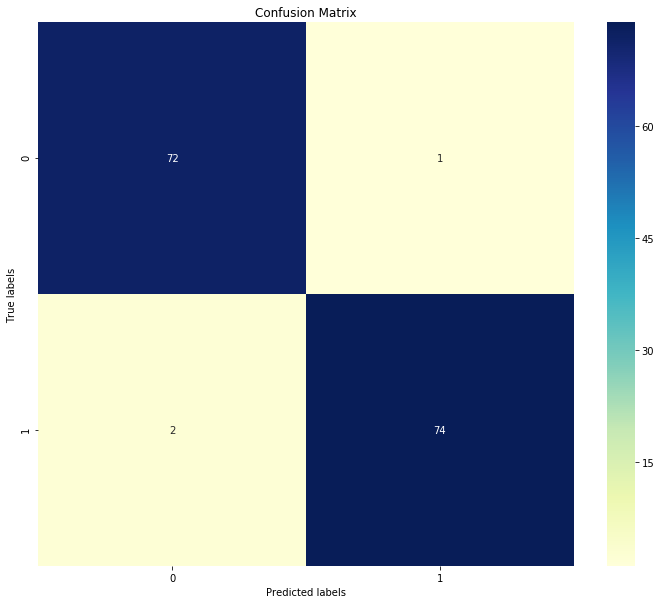

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 基于之前的预测结果计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(12, 10))  # 根据需要调整图像的大小
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(len(np.unique(all_labels))), yticklabels=range(len(np.unique(all_labels))))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

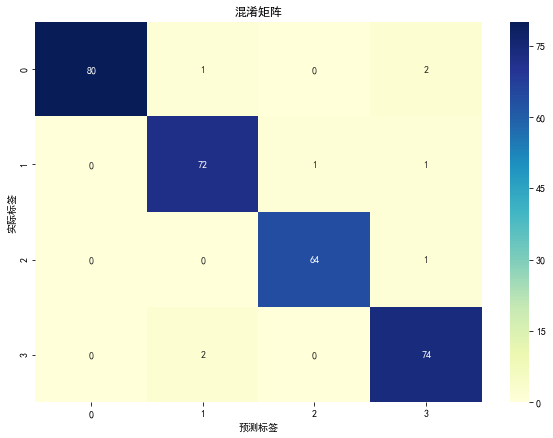

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# 配置matplotlib以支持中文显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 使用你所提供的混淆矩阵的值
cm = np.array([
    [80, 1, 0, 2],
    [0, 72, 1, 1],
    [0, 0, 64, 1],
    [0, 2, 0, 74]
])

# 使用seaborn的heatmap函数绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")

# 添加轴标签和标题
plt.ylabel('实际标签')
plt.xlabel('预测标签')
plt.title('混淆矩阵')

# 显示图形
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Your confusion matrix
confusion_matrix = np.array([
    [80, 1, 0, 2],
    [0, 72, 1, 1],
    [0, 0, 64, 1],
    [0, 2, 0, 74]
])

# Flatten the confusion matrix for multi-class evaluation
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[i])):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for unweighted mean
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9731543624161074
Precision: 0.9733333333333334
Recall: 0.9737819974503552
F1 Score: 0.973423097674755
